# Treatment Scheduling

Use the basic TGI models to inform simple rules-of-thumb about treatment sequencing

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps

from treatment_sequencing import GrowthInhibitionModel, GillespieTGIModel


## Sequential Treatments (Ordering Problem)

### Varying Evolution Speed

Let us consider three treatments, with the same initial efficacy but different resistance evolution speeds. Which is the optimal drug ordering? 

For this initial problem, we will switch at the nadir of each drug treatment. Using the lessons from [`base_TGI_model`](base_TGI_model.ipynb), we know this occurs when $\lambda = \gamma(t)$; we may show that this occurs for $t = \frac{1}{\epsilon}ln \left( \frac{\gamma_{0}}{\lambda} \right)$.

In [22]:
def treatment_comparison_plot(t_max, lambda_vals, epsilon_vals, gamma0_vals=[1,1,1], V0_vals=[1,1,1]):
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    titles = ['Slow', 'Medium', 'Fast']

    for i, ax in enumerate(axs):
        params = {'lambda': lambda_vals[i], 'epsilon': epsilon_vals[i], 'V0': V0_vals[i], 'gamma0': gamma0_vals[i]}
        model = GrowthInhibitionModel(params=params, method='Radau', dt = 0.11)
        model.simulate(t_max=t_max)
        model.plot(ax=ax, linewidth=4, label='Drug Response')
        ax.set_ylim([0, 2]); ax.set_xlim(0, t_max)
        ax.set_title(titles[i] + f" Resistance \n $\epsilon$ = {epsilon_vals[i]}")
        
        ax.vlines(ymin=0, ymax=2, x=np.log(gamma0_vals[i]/lambda_vals[i])/epsilon_vals[i],
                  color='gray', linestyle=':', linewidth=4, label='Nadir Time')
      
    axs[0].legend(loc=2)   
    return fig, axs

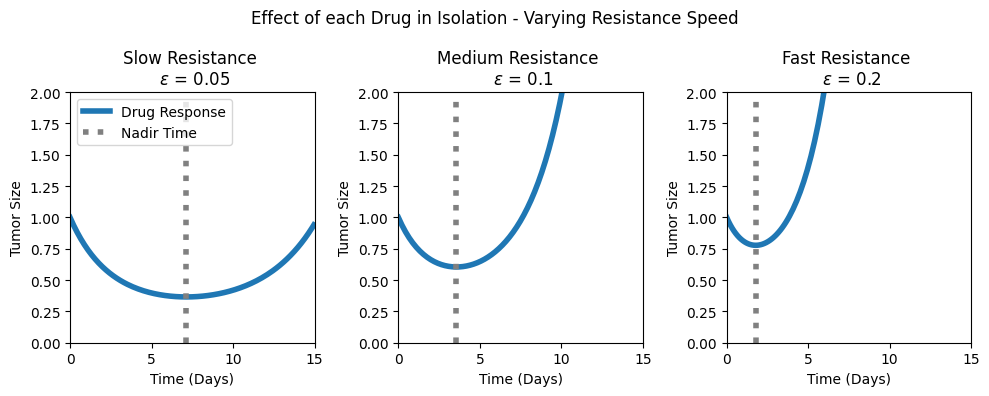

In [120]:
V0 = 1; gamma0 = 1; t_max = 15
lambda_vals = [0.7, 0.7, 0.7]
epsilon_vals = [0.05, 0.1, 0.2]

fig, axs = treatment_comparison_plot(t_max, lambda_vals, epsilon_vals)

plt.suptitle("Effect of each Drug in Isolation - Varying Resistance Speed"); plt.tight_layout()

In [121]:
def compare_df(df1, df2):
    percent_change_ttp = 100*(df2.Time.iloc[-1] - df1.Time.iloc[-1])/df1.Time.iloc[-1]
    print(f"Change in TTP: {df2.Time.iloc[-1] - df1.Time.iloc[-1]:.0f} days, or {percent_change_ttp:.1f}%")
    
    print(f"Change in mean tumour size: {100*((df2.V.mean()- df1.V.mean()) / df1.V.mean()):.1f}%")
    print(f"Change in min tumour size: {100*((df2.V.min()- df1.V.min()) / df1.V.min()):.1f}%")
    

In [124]:
def plot_drug_sequence(ax, seq, cols, lambda_vals, epsilon_vals, gamma0_vals=[1,1,1], V0=1, prog_thresh=2):
    # Plot sequence of each drug, stopping at the minimum tumor size for each treatment type
    
    time=0
    initial_size = V0
    
    for i,n in enumerate(seq):  # i is treatment index, n is drug number
        nadir_time = np.log(gamma0_vals[n]/lambda_vals[n])/epsilon_vals[n]
        end_time = nadir_time if i < len(seq)-1 else 20 * nadir_time  # Continue to progression at end
            
        params = {'lambda': lambda_vals[n], 'epsilon': epsilon_vals[n], 'V0': V0, 'gamma0': gamma0_vals[n]}
        model = GrowthInhibitionModel(params=params, method='Radau', dt = 0.11)
        model.simulate(t_max=end_time); model.results_df['Time'] += time
        
        if i < len(seq)-1:  # Not the final treatment
            V0 = model.results_df['V'].iloc[-1]
        else:  # Curtail final treatment to twice initial size
            model.results_df = model.results_df[model.results_df['V'] < prog_thresh * initial_size]

        model.plot(ax=ax, linewidth=4, color=cols[n], label=('Drug ' + str(n))) #, linestyle=['-', '--', ':'][n])
        time = max(model.results_df['Time'])
        
        if i == 0:
            full_df = model.results_df.copy()
        else:
            full_df = pd.concat([full_df, model.results_df])
        
    ax.legend(); ax.set_ylim(0, prog_thresh * initial_size); #ax.set_xlim(left=0)
    return full_df

Change in TTP: 5 days, or 27.6%
Change in mean tumour size: 1.0%
Change in min tumour size: -0.0%


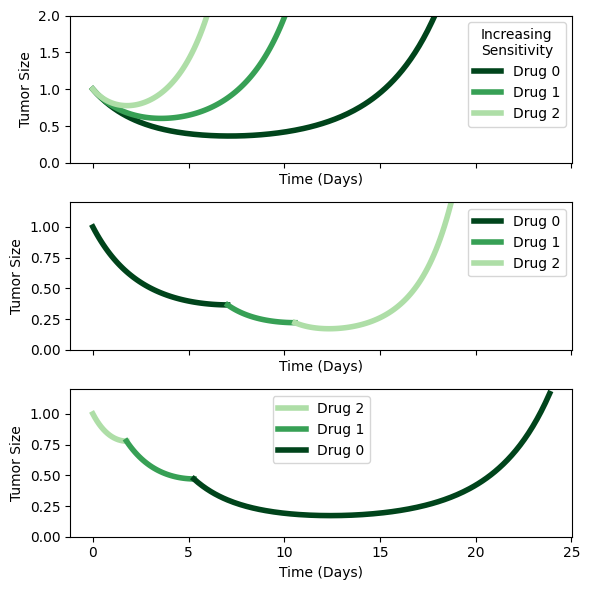

In [147]:
fig, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

cols = colormaps.get_cmap('Greens_r')(np.linspace(0, 1, 4))[:-1]

for i, col in enumerate(cols):
    plot_drug_sequence(axs[0], [i], cols, lambda_vals, epsilon_vals, prog_thresh=2) 

dec_sensitivity_df = plot_drug_sequence(axs[1], [0, 1, 2], cols, lambda_vals, epsilon_vals, prog_thresh=1.2)  
inc_sensitivity_df = plot_drug_sequence(axs[2], [2, 1, 0], cols, lambda_vals, epsilon_vals, prog_thresh=1.2)  
axs[0].get_legend().set_title("Increasing\nSensitivity"); 

compare_df(dec_sensitivity_df, inc_sensitivity_df)

Therefore, we can see there is a significant benefit in scheduling drugs in the order of **increasing sensitivity retention**, so that the '_best_' drugs in this respect are scheduled last - counter-intuitive benefit for the clinic (although many caveats here...)?

### Varying initial efficacy

We may also consider the role of initial efficacy in this context, and the impact of this on the overall time to progression.

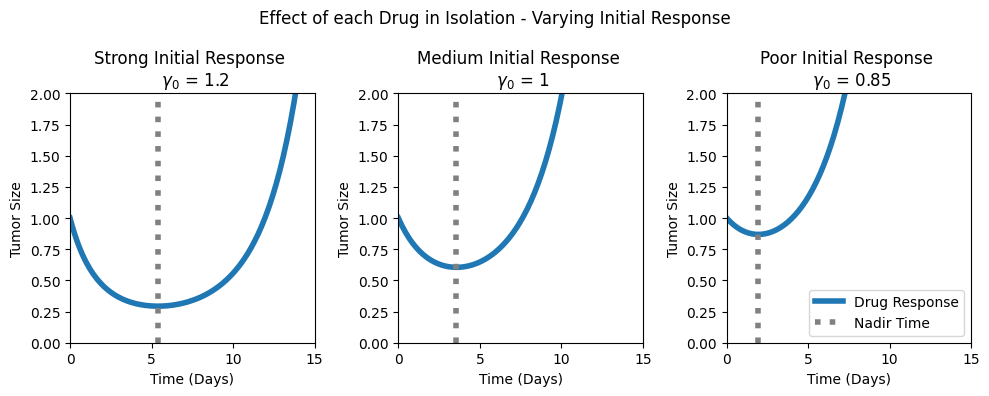

In [134]:
epsilon_vals_ie = [0.1, 0.1, 0.1]
gamma0_vals_ie = [1.2, 1, 0.85]
strengths = ['Strong', 'Medium', 'Poor']


fig, axs = treatment_comparison_plot(t_max, lambda_vals, epsilon_vals_ie, gamma0_vals=gamma0_vals_ie)
axs[2].legend(loc=4); axs[0].get_legend().remove()

for i, ax in enumerate(axs):
    ax.set_title(strengths[i] + f" Initial Response \n $\gamma_{0}$ = {gamma0_vals_ie[i]}")

plt.suptitle("Effect of each Drug in Isolation - Varying Initial Response"); plt.tight_layout()

Change in TTP: 0 days, or 0.0%
Change in mean tumour size: 19.1%
Change in min tumour size: -0.0%


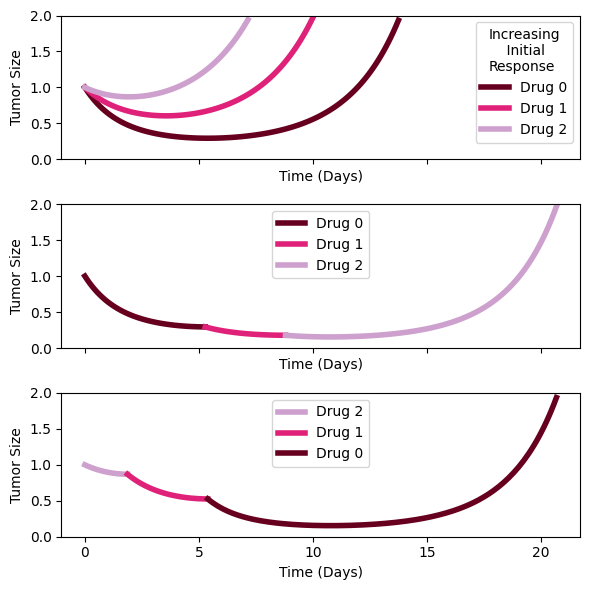

In [152]:
cols = colormaps.get_cmap('PuRd_r')(np.linspace(0, 1, 4))[:-1]

fig, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True, sharey=True)
for i, col in enumerate(cols):
    plot_drug_sequence(axs[0], [i], cols, lambda_vals, epsilon_vals_ie, gamma0_vals=gamma0_vals_ie) 

dec_sensitivity_df = plot_drug_sequence(axs[1], [0, 1, 2], cols, lambda_vals, epsilon_vals_ie, gamma0_vals=gamma0_vals_ie)  
inc_sensitivity_df = plot_drug_sequence(axs[2], [2, 1, 0], cols, lambda_vals, epsilon_vals_ie, gamma0_vals=gamma0_vals_ie)  
axs[0].get_legend().set_title("Increasing\n    Initial\nResponse"); 

compare_df(dec_sensitivity_df, inc_sensitivity_df)

We can see that changing the sequence of drugs with different initial efficacies does not impact the overall time to progression. However, it does reduce the mean tumor burden over time, reducing the impact on the patient, and so the most efficient drugs should be scheduled first.

We hope these broad scheduling principles can inform decision-making for clinicans, who are able to weigh up the relative importance of TTP and mean tumor burden on a case-by-case basis.

## Cycling treatments (Timing Problem)

Given this order, how may we then consider cycling treatments - how long should we keep each treatment on for. Start by switching at each nadir, but if we switch earlier (when response rate has dropped by a given factor) then is this beneficial? Each drug's sensitivity increases at a constant rate off treatment, all off treatment

## Information Delays

How may we account for information delays in model? Could use model to predict where patient will be in a week, to generate a personalised threshold for response rate. 

## Virtual Cohort

Introduce gillespie model to account for stochasticity in patient response, and simulate multiple iterations, with parameters sampled from given distribution. How to account for this variation - identify patients with faster tumor dynamics for more frequent follow up and earlier intervention